In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import read_corpus, batch_iter

from vocab import Vocab, VocabEntry
from node_model import Node
import torch

from seaborn import heatmap

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/austinmurphy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austinmurphy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
mod = Node.load('node_models_2bilstm_500.bin')
mod.eval()

vocab.num_labels:  19
vocab.num_labels:  19
vocab.num_labels:  19


Node(
  (model_embeddings): ModelEmbeddings(
    (note_embeds): Embedding(12808, 256, padding_idx=0)
  )
  (first_bilstm): BiLSTM(
    (model_embeddings): ModelEmbeddings(
      (note_embeds): Embedding(12808, 256, padding_idx=0)
    )
    (encoder): LSTM(256, 256, bidirectional=True)
    (dropout1): Dropout2d(p=0.3)
    (dropout2): Dropout(p=0.3)
    (attention_projection): Linear(in_features=512, out_features=19, bias=False)
    (attention_softmax): Softmax()
    (labels_projection): Linear(in_features=512, out_features=1, bias=False)
  )
  (second_bilstm): BiLSTM(
    (model_embeddings): ModelEmbeddings(
      (note_embeds): Embedding(12808, 256, padding_idx=0)
    )
    (encoder): LSTM(256, 256, bidirectional=True)
    (dropout1): Dropout2d(p=0.3)
    (dropout2): Dropout(p=0.3)
    (attention_projection): Linear(in_features=512, out_features=19, bias=False)
    (attention_softmax): Softmax()
    (labels_projection): Linear(in_features=512, out_features=1, bias=False)
  )
)

In [3]:
lay = 0
first_bi = None
for child in mod.children():
    if lay==1:
        print(child)
        first_bi = child
    print()
    lay += 1


BiLSTM(
  (model_embeddings): ModelEmbeddings(
    (note_embeds): Embedding(12808, 256, padding_idx=0)
  )
  (encoder): LSTM(256, 256, bidirectional=True)
  (dropout1): Dropout2d(p=0.3)
  (dropout2): Dropout(p=0.3)
  (attention_projection): Linear(in_features=512, out_features=19, bias=False)
  (attention_softmax): Softmax()
  (labels_projection): Linear(in_features=512, out_features=1, bias=False)
)




In [4]:
first_bi.parameters

<bound method Module.parameters of BiLSTM(
  (model_embeddings): ModelEmbeddings(
    (note_embeds): Embedding(12808, 256, padding_idx=0)
  )
  (encoder): LSTM(256, 256, bidirectional=True)
  (dropout1): Dropout2d(p=0.3)
  (dropout2): Dropout(p=0.3)
  (attention_projection): Linear(in_features=512, out_features=19, bias=False)
  (attention_softmax): Softmax()
  (labels_projection): Linear(in_features=512, out_features=1, bias=False)
)>

In [ ]:
## Can I get all parameters up to attention_softmax? 

In [57]:
# temp = torch.nn.Module()

In [59]:
# ## Copies exactly but no longer has declared forward function...
# for name, module in first_bi.named_children():
# #     if name in ['conv4', 'conv5']:
#     if name == "labels_projection":
#         break
#     print(name, " ** ", module)
#     temp.add_module(name, module)
    

model_embeddings  **  ModelEmbeddings(
  (note_embeds): Embedding(12808, 256, padding_idx=0)
)
encoder  **  LSTM(256, 256, bidirectional=True)
dropout1  **  Dropout2d(p=0.3)
dropout2  **  Dropout(p=0.3)
attention_projection  **  Linear(in_features=512, out_features=19, bias=False)
attention_softmax  **  Softmax()


In [7]:
# interp_mod = Node
vocab = Vocab.load('vocab.json')

In [8]:
from collections import namedtuple
import sys
from typing import List, Tuple, Dict, Set, Union
import torch
import torch.nn as nn
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import numpy as np

from model_embeddings import ModelEmbeddings


class BiLSTM_interp(nn.Module):
    """
    Simple Neural Multilabel Classification Model:
    - Bidirectional LSTM Encoder
    """
    def __init__(self, embed_size, hidden_size, vocab, dropout_rate):
        super(BiLSTM_interp, self).__init__()
        self.model_embeddings = ModelEmbeddings(embed_size, vocab)
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.vocab = vocab
        print("vocab.num_labels: ", vocab.num_labels)
        self.num_labels = vocab.num_labels
        
        self.encoder = nn.LSTM(input_size=embed_size,
                               hidden_size=hidden_size, 
                               bias=True, 
#                                dropout=self.dropout_rate,
                               bidirectional=True)
        
        self.dropout1 = nn.Dropout2d(p=self.dropout_rate)
        self.dropout2 = nn.Dropout(p=self.dropout_rate)
        
        self.attention_projection = nn.Linear(in_features=2*hidden_size, 
                                                 out_features=self.num_labels, 
                                                 bias=False)
        self.attention_softmax = nn.Softmax(dim=0)
        self.labels_projection = nn.Linear(in_features=2*hidden_size, 
                                          out_features=1, 
                                          bias=False)
        
    def forward(self, in_sents: List[List[str]], target_labels: List[List[int]]):
        # Compute sentence lengths
        in_sents_lengths = [len(s) for s in in_sents]
        
        # Convert list of lists into tensors
        source_padded = self.vocab.notes_.to_input_tensor(in_sents, device=self.device)   
                # Tensor: (src_len, b)
        
#         print("len(in_sents): ", len(in_sents))
#         print("source_padded.shape: ", source_padded.shape)
#         print(target_labels.shape)

        X = self.model_embeddings.note_embeds(source_padded)
#         print("X.shape: ", X.shape) (500, 16, 256) == (note length, batch_size, embedding length)
        
        enc_hiddens, (last_hidden, last_cell) = self.encoder(X)
#         print("enc_hiddens.shape: ", enc_hiddens.shape) 
#                 (500, 16, 512) == (note length, batch_size, hidden_size)

#         enc_hiddens = self.dropout1(enc_hiddens)
        
        alpha = self.attention_projection(enc_hiddens)
#         print("alpha.shape: ", alpha.shape) (500, 16, 19)

        alpha = self.dropout1(alpha)
        
        alpha_soft = self.attention_softmax(alpha)
#         print("alpha_soft.shape: ", alpha_soft.shape) (500, 16, 19)
        # for each label, a 500-length probability vector of alphas
#         print(sum(alpha_soft[:,0,0]))
#         print(sum(alpha_soft[0,0,:]))
#         print(np.sum(alpha_soft.detach().numpy(),axis=0))
        

# #         print("alpha_permuted shape: ", alpha_soft.permute([2,1,0]).shape)
        
#         M = torch.bmm(alpha_soft.permute([1,2,0]), enc_hiddens.permute([1,0,2]))
# #         print("M.shape: ", M.shape) (16, 19, 512) == (batch_size, num labels, hidden_size)
# #         torch.stack(combined_outputs, dim=0)

# #         M = self.dropout2(M)

#         scores = self.labels_projection(M)
# #         print(scores)
# #         print(F.sigmoid(scores))
#         scores = torch.sigmoid(torch.squeeze(scores,-1))
# #         print("scores.shape: ", scores.shape)
# #         print("scores squeezed shape: ", torch.squeeze(scores,-1).shape)
# #         print("scores: \n", scores)
# #         scores = 0.
        
        return alpha_soft
    
    
    def encode(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        pass
    
    @property
    def device(self) -> torch.device:
        """ Determine which device to place the Tensors upon, CPU or GPU.
        """
        return self.model_embeddings.note_embeds.weight.device
    
    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        """
#         params = torch.load(model_path, map_location=lambda storage, loc: storage)
#         args = params['args']
#         model = NMT(vocab=params['vocab'], **args)
#         model.load_state_dict(params['state_dict'])
        
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = BiLSTM(vocab=params['vocab'], **args)
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, path: str):
        """ Save the odel to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)

#         params = {
#             'args': dict(embed_size=self.model_embeddings.embed_size, hidden_size=self.hidden_size, dropout_rate=self.dropout_rate),
#             'vocab': self.vocab,
#             'state_dict': self.state_dict()
#         }
        
        params = {
            'args': dict(embed_size=self.model_embeddings.embed_size, hidden_size=self.hidden_size, dropout_rate=self.dropout_rate),
            'vocab': self.vocab,
            'state_dict': self.state_dict()
        }

        torch.save(params, path)
        

In [9]:
temp2 = BiLSTM_interp(256, 256, vocab, 0.3)

vocab.num_labels:  19


In [10]:
for i in temp2.named_parameters():
    print(i)

('model_embeddings.note_embeds.weight', Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2039, -0.3024,  0.0938,  ...,  0.2448,  0.5316,  0.6707],
        [ 1.3978,  0.1401, -0.6901,  ..., -0.9123, -0.1819, -0.3283],
        ...,
        [-1.2226,  2.4622,  0.4368,  ..., -1.2296,  0.7579, -1.1803],
        [ 1.6096,  1.2757, -0.0045,  ...,  0.3448, -0.2841,  0.3463],
        [ 2.1500, -1.4873, -0.2790,  ...,  0.9441, -0.3763, -0.7299]],
       requires_grad=True))
('encoder.weight_ih_l0', Parameter containing:
tensor([[-0.0296,  0.0595,  0.0332,  ..., -0.0333,  0.0568,  0.0210],
        [-0.0098, -0.0270,  0.0232,  ..., -0.0212,  0.0397,  0.0486],
        [-0.0115,  0.0119, -0.0432,  ..., -0.0339, -0.0099, -0.0318],
        ...,
        [-0.0587, -0.0161, -0.0384,  ..., -0.0415,  0.0231,  0.0506],
        [ 0.0576, -0.0459, -0.0200,  ..., -0.0428, -0.0246, -0.0529],
        [ 0.0215, -0.0443, -0.0354,  ..., -0.0584,  0.0376, -0.012

In [11]:
for nameish, i in temp2.named_parameters():
    print(nameish)


model_embeddings.note_embeds.weight
encoder.weight_ih_l0
encoder.weight_hh_l0
encoder.bias_ih_l0
encoder.bias_hh_l0
encoder.weight_ih_l0_reverse
encoder.weight_hh_l0_reverse
encoder.bias_ih_l0_reverse
encoder.bias_hh_l0_reverse
attention_projection.weight
labels_projection.weight


In [12]:
for i in temp2.named_parameters():
    print(i)

('model_embeddings.note_embeds.weight', Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2039, -0.3024,  0.0938,  ...,  0.2448,  0.5316,  0.6707],
        [ 1.3978,  0.1401, -0.6901,  ..., -0.9123, -0.1819, -0.3283],
        ...,
        [-1.2226,  2.4622,  0.4368,  ..., -1.2296,  0.7579, -1.1803],
        [ 1.6096,  1.2757, -0.0045,  ...,  0.3448, -0.2841,  0.3463],
        [ 2.1500, -1.4873, -0.2790,  ...,  0.9441, -0.3763, -0.7299]],
       requires_grad=True))
('encoder.weight_ih_l0', Parameter containing:
tensor([[-0.0296,  0.0595,  0.0332,  ..., -0.0333,  0.0568,  0.0210],
        [-0.0098, -0.0270,  0.0232,  ..., -0.0212,  0.0397,  0.0486],
        [-0.0115,  0.0119, -0.0432,  ..., -0.0339, -0.0099, -0.0318],
        ...,
        [-0.0587, -0.0161, -0.0384,  ..., -0.0415,  0.0231,  0.0506],
        [ 0.0576, -0.0459, -0.0200,  ..., -0.0428, -0.0246, -0.0529],
        [ 0.0215, -0.0443, -0.0354,  ..., -0.0584,  0.0376, -0.012

In [13]:
temp2.model_embeddings.note_embeds.weight.data = first_bi.model_embeddings.note_embeds.weight.data
temp2.encoder.weight_ih_l0.data = first_bi.encoder.weight_ih_l0.data
temp2.encoder.weight_hh_l0.data = first_bi.encoder.weight_hh_l0.data
temp2.encoder.bias_ih_l0.data = first_bi.encoder.bias_ih_l0.data
temp2.encoder.bias_hh_l0.data = first_bi.encoder.bias_hh_l0.data
temp2.encoder.weight_ih_l0_reverse.data = first_bi.encoder.weight_ih_l0_reverse.data
temp2.encoder.weight_hh_l0_reverse.data = first_bi.encoder.weight_hh_l0_reverse.data
temp2.encoder.bias_ih_l0_reverse.data = first_bi.encoder.bias_ih_l0_reverse.data
temp2.encoder.bias_hh_l0_reverse.data = first_bi.encoder.bias_hh_l0_reverse.data
temp2.attention_projection.weight.data = first_bi.attention_projection.weight.data
temp2.labels_projection.weight.data = first_bi.labels_projection.weight.data

# model_embeddings.note_embeds.weight
# encoder.weight_ih_l0
# encoder.weight_hh_l0
# encoder.bias_ih_l0
# encoder.bias_hh_l0
# encoder.weight_ih_l0_reverse
# encoder.weight_hh_l0_reverse
# encoder.bias_ih_l0_reverse
# encoder.bias_hh_l0_reverse
# attention_projection.weight
# labels_projection.weight


In [66]:
temp2.eval()

BiLSTM_interp(
  (model_embeddings): ModelEmbeddings(
    (note_embeds): Embedding(12808, 256, padding_idx=0)
  )
  (encoder): LSTM(256, 256, bidirectional=True)
  (dropout1): Dropout2d(p=0.3)
  (dropout2): Dropout(p=0.3)
  (attention_projection): Linear(in_features=512, out_features=19, bias=False)
  (attention_softmax): Softmax()
  (labels_projection): Linear(in_features=512, out_features=1, bias=False)
)

In [14]:
# Try running the data through:

In [22]:
small_notes = read_corpus(file_path='./data/small/test_text.csv', column='text', sent_max_length=500, remove_stopwords=True)
small_labels = read_corpus(file_path='./data/small/test_labels.csv', column='labels', sent_max_length=500, remove_stopwords=True)

Processed 1101 lines.
Processed 1101 lines.


In [23]:
small_notes
small_labels

[[2, 3, 6, 9, 17],
 [2, 5, 6, 16, 17],
 [0, 2, 3, 5, 6, 7, 9, 11, 16, 17, 18],
 [6, 7, 9, 17],
 [0, 3, 4, 6, 15, 16],
 [0, 2, 4, 6, 7, 8, 9],
 [0, 2, 4, 6, 7, 12, 15],
 [3, 6, 16, 18],
 [2, 6, 17],
 [0, 1, 2, 7, 9, 16],
 [2, 5, 6, 8, 11, 18],
 [1, 6, 7, 17],
 [0, 3, 7, 8, 9, 15, 16],
 [4, 5, 6, 7],
 [1, 2, 6, 8],
 [2, 6, 9, 16],
 [0, 2, 4, 5, 6, 7, 9, 15, 16],
 [0, 2, 3, 5, 6, 7, 8],
 [3, 4],
 [0, 2, 5, 6, 7, 9],
 [2, 4, 6, 7, 9, 12, 17],
 [0, 3, 7, 8, 9, 15],
 [2, 3, 4, 5, 6, 15, 16, 17, 18],
 [15, 16, 17],
 [0, 6, 7, 8, 11, 15, 16, 17],
 [2, 5, 6, 9, 12],
 [2, 4, 6, 7, 9, 16, 18],
 [0, 2, 3, 6, 7, 9, 11, 15, 16, 17],
 [0, 1, 2, 4, 5, 7, 8, 9, 15, 16],
 [0, 2, 6, 7, 8],
 [6],
 [0, 3, 5, 6, 7, 8, 9, 11, 15, 16, 17, 18],
 [2, 5, 6, 7, 8, 9, 16, 17, 18],
 [2, 6, 9, 16],
 [3, 5, 6, 8, 11, 12, 15, 16, 17],
 [1, 6, 15, 17],
 [6, 7, 11, 16],
 [1, 2, 3, 5, 7, 9],
 [2, 6, 9, 16, 18],
 [7, 12, 16, 18],
 [2, 6, 12, 15, 16],
 [0, 5, 6, 7, 9, 15, 17],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 17, 18],
 [0, 1, 

In [24]:
small_labels[0]

[2, 3, 6, 9, 17]

In [25]:
test_data = list(zip(small_notes, small_labels))

In [111]:
def pay_attention(idx):
    it = 0
    for notes, labs in batch_iter(test_data, batch_size=1, shuffle=False):
        if it == idx:
            scores = first_bi(notes, labs).detach().numpy()[0]
            attention_output = temp2(notes, labs).detach().numpy().squeeze()
            return scores, attention_output
        it += 1

In [150]:
idx=6
scores, attention_output = pay_attention(idx=idx)

predictions = np.zeros(19)
predictions[scores>=.5] = 1
print(predictions)
print(small_labels[0])
print(attention_output.shape)

[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[2, 3, 6, 9, 17]
(500, 19)


In [161]:
attention_output

array([[0.00010649, 0.00065069, 0.05074167, ..., 0.00069604, 0.01345824,
        0.00419825],
       [0.00017084, 0.0006749 , 0.00848822, ..., 0.00026989, 0.01145524,
        0.00188814],
       [0.0001362 , 0.0009693 , 0.00145168, ..., 0.00019169, 0.01263757,
        0.00213418],
       ...,
       [0.00054771, 0.00532075, 0.00019089, ..., 0.00093116, 0.00258023,
        0.00218325],
       [0.0004858 , 0.00402783, 0.0003628 , ..., 0.00100914, 0.00313539,
        0.00219409],
       [0.00070507, 0.00379382, 0.0002777 , ..., 0.00119278, 0.00218225,
        0.0021517 ]], dtype=float32)

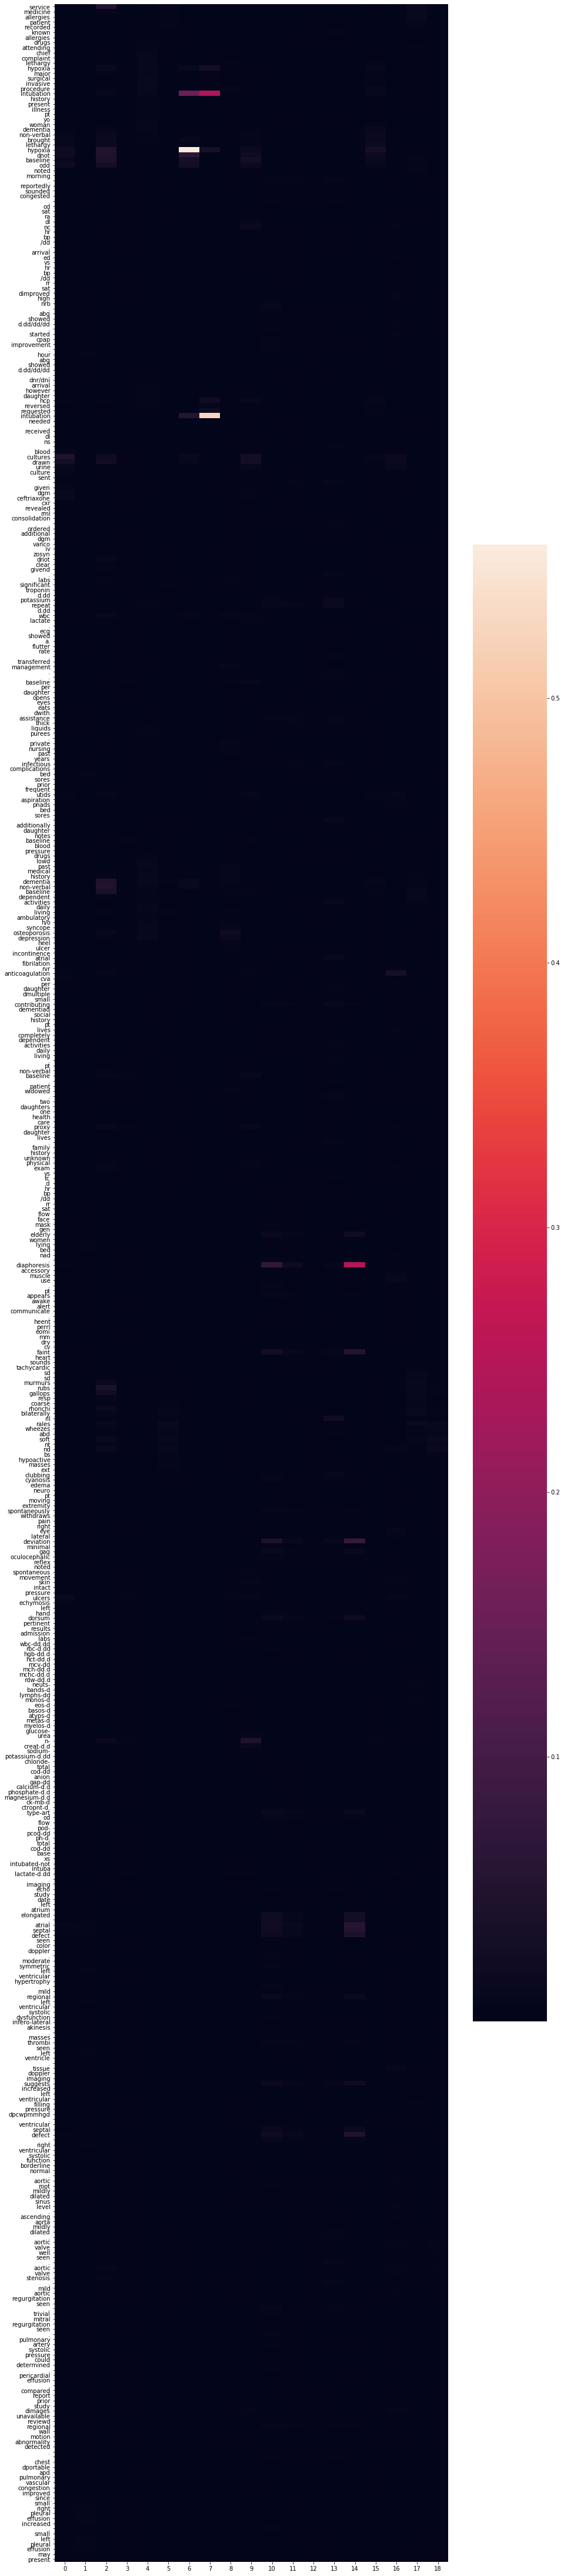

In [151]:
fig, ax = plt.subplots(figsize=(15,80))
heatmap(attention_output, yticklabels=small_notes[idx])
plt.show()

In [134]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def colorize(words, color_array):
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
#     cmap = matplotlib.cm.get_cmap('RdBu')
    cmap = matplotlib.cm.get_cmap('Reds')
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string
    
words = 'The quick brown fox jumps over the lazy dog'.split()
color_array = np.random.rand(len(words))
s = colorize(words, color_array)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

# or simply save in an html file and open in browser
with open('colorize.html', 'w') as f:
    f.write(s)

In [164]:
ss = colorize(words=small_notes[idx], color_array=attention_output[:,6])
display(HTML(ss))

In [159]:
ss = colorize(words=small_notes[idx], color_array=attention_output[:,9]*10)
display(HTML(ss))